## Question 1. ZLG algorithm implementation (50 points)
**You are to implement the ZLG algorithm for this problem.**
- **We will use a subset of multiclass data where the label is a protein subcellular localization.**
- **The 8 features are extracted from the protein sequence.**
- **For this problem we are only using points with labels `MIT` or `NUC`.**
- **A total of 892 data points have labels `MIT` (244) or `NUC` (429). We start with the labels of only the first 200 data points (set `Y_k`). The other 792 points are in `Y_u`.**

**First, read the paper and answer the following questions.**
#### 1. What is the idea behind the ZLG algorithm (5 points)?
#### 2. What are the assumptions behind the ZLG algorithm (5 points)?
#### 3. What are the pros and cons of the ZLG algorithm (5points)?

### Imports

In [1]:
import numpy as np
import pandas as pd 
import copy
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder

import packages.zlg.zlg as zlg

### Data Prep

In [2]:
data = pd.read_csv('data/data.csv')
print('shape',data.shape)
print('unique labels', data.Label.unique())
data.head(5)

shape (673, 9)
unique labels ['MIT' 'NUC']


,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
# filter out records without desired labels
data_MITNUC = data.loc[data['Label'].isin(['MIT','NUC'])].values

# split data into features and target, encode target classes as 0 or 1
X = data_MITNUC[:,:8]
y = LabelEncoder().fit_transform(data_MITNUC[:,-1])

print(X.shape)
print(y.shape)

(673, 8)
(673,)


In [4]:
# split data into first 200 records and remainder
n_l = 200

Xk = X[:n_l,:]
Yk = y[:n_l]
Xu = X[n_l:,:]
Yu = y[n_l:]

print(Xk.shape)
print(Yk.shape)
print(Xu.shape)
print(Yu.shape)

(200, 8)
(200,)
(473, 8)
(473,)


# 1.1. Part 1 (5 points)
**TODO:**
- **Let's first construct the weight matrix W.**
- **Use $t = 0$ and $\sigma$ as the standard deviation of $X$.**
- **Then calculate the $D$ matrix and the Laplacian matrix (Delta).**

### Formulas
Similarity is measured using the radial basis function (RBF):

This paper:
$$w_{ij}=\exp{\left( -\frac{1}{\sigma^2}\sum_{d=1}^m (x_{id} - x_{jd})^2 \right)}$$

Another paper (https://www.aaai.org/Papers/ICML/2003/ICML03-118.pdf):

$$w_{ij}=\exp{\left( -\sum_{d=1}^m \frac{(x_{id} - x_{jd})^2}{\sigma^2_d} \right)}$$












where
- $x_i \in \mathbb{R}^m$
- $x_{id}$ is the $d$-th component  of instance $x_i$
- $\sigma_1, \ldots ,\sigma_m$ are length scale hyperparameters for each dimension


Note: $\sum_{d=1}^m \left( x_{id} - x_{jd} \right)^2$ is the squared Euclidean distance between $x_i$ and $x_j$

I think I understand what you mean about flattening the matrix, but it doesn't make sense to me. Let me explain. 


Consider the inner expression:

$$ \frac{1}{\sigma^2}\sum_{d=1}^m (x_{id} - x_{jd})^2$$


Suppose:

$$X=\begin{bmatrix}1 && 2 \\ 3 && 5\end{bmatrix}$$

where

$$x_1=\begin{bmatrix}1 && 2 \end{bmatrix}$$

$$x_2=\begin{bmatrix}3 && 5 \end{bmatrix}$$

We can calculate the variance of each of the columns:

$$v=\begin{bmatrix}1 && 2.25 \end{bmatrix}$$


If we use `distance_matrix()`, referenced in the Notebook, the squared distance matrix of $X$ would be:

$$X=\begin{bmatrix}0 && 13 \\ 13 && 0\end{bmatrix}$$

If we now multiply the two terms together, we would get this as the inner result:

$$\frac{1}{v} \cdot X = \begin{bmatrix}0 && 5.78 \\ 5.78 && 0\end{bmatrix}$$

with the inner term 5.78 representing the result of the expression.

However, consider the version of the RBF in this paper referenced by the authors (https://www.aaai.org/Papers/ICML/2003/ICML03-118.pdf):

$$w_{ij}=\exp{\left( -\sum_{d=1}^m \frac{(x_{id} - x_{jd})^2}{\sigma^2_d} \right)}$$

In this version, it clearly seems to show that we should be dividing each term by the variance of that term. I can't find a more efficient way to do it other than term by term. But if we do that, we get a different value.

$$\frac{(3-1)^2}{1}+\frac{(5-2)^2}{2.25}=8$$


$$8 \ne 5.78$$


To me, it clearly seems like these two approaches get different results. Am I looking at this the wrong way?



In [6]:
# laplacian_matrix() implemented in custom Python package zlg

# 1.2. Part 2 (5 points) 
**TODO:**
- **Now complete the subroutine to compute the minimum-energy solution for the unlabeled instances. (Hint: Use the formula in page 38, Lecture 7.)** 
- **The function also outputs one submatrix that we will use to select points to query.**

In [7]:
# minimum_energy_solution() implemented in custom Python package zlg

# 1.3. Part 3 (15 points) 
**TODO:**
- **We would like to query the points that minimize the expected risk. To do so, we want to be able to calculate the expected estimated risk after querying any point $k$.**
- **The variable `Rhat_fplus_xk` refers to $\hat{R}(f^{+x_k})$.**
- **`fu_xk0` is $f_u^{+(x_k,0)}$ and vice versa for `fu_xk1`.**

I'm confused about the notation involved in calculating expected risk for ZLG. In the paper, we have the following equations:

#### Expected risk:

$$\hat{R}\left( f^{+(x_k,y_k)} \right)=\sum_{i=1}^n min\left( f_i^{+(x_k,y_k)},1-f_i^{+(x_k,y_k)}\right)$$

#### Expected estimated risk:

$$\hat{R}\left( f^{+x_k} \right)=
(1-f_k)\hat{R}\left( f^{+(x_k,0)} \right)
+   f_k\hat{R}\left( f^{+(x_k,1)} \right)$$


#### Conditional Distribution of all unlabeled nodes:

$$f_u^{+(x_k,y_k)}=f_u+(y_k-f_k)\frac{(\Delta_{uu}^{-1})_{ \cdot k}}{(\Delta_{uu}^{-1})_{kk}}$$


***

I'm confused at the difference between $f_u$ and $f$ and $f_i$. The paper defines $f=\begin{bmatrix}f_l \\ f_u\end{bmatrix}$ but I don't understand how exactly this works through the equations above. My understanding is that $f_u$ is a vector. I calculated that $f_u^{+(x_k,0)}$ is a vector of the same dimension.  

Is $f^{+(x_k,0)}$ the same as $f_u^{+(x_k,0)}$?

***

I'm also confused at how to calculate estimated risk.

$$\hat{R}\left( f^{+(x_k,0)} \right)=\sum_{i=1}^n min\left( f_i^{+(x_k,0)},1-f_i^{+(x_k,0)}\right)$$

What is the $n$ in this case? I thought we were dealing with $f_u$. What would $f_1, f_2, \ldots, f_n$ be?

***







In [8]:
# expected_estimated_risk() implemented in custom Python package zlg

# 1.4. Part 4 (5 points) 
**TODO:**
- **Compute the above expected estimated risk for all unlabeled points and select one to query.**

In [9]:
# zlg_query() implemented in custom Python package zlg

# 1.5. Part 5
**TODO:**
- **Let's try query 100 points. Which points are queried?** 
- **Compare with random queries and make a plot.**

In [11]:
def score_model(f_u, y_true):
    y_pred = np.round(f_u)
    
    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError('Arrays must be the same size to compare.')
    
    err_count = 0
    for i in range(y_pred.shape[0]):
        if y_pred[i] != y_true[i]:
            err_count += 1
    
    return (y_pred.shape[0]-err_count) / y_pred.shape[0]


print('test score_model()')
a = np.array([0.5,0.7,0.1])
b = np.array([1,0,0])
assert score_model(a,b) == 1/3

test score_model()


In [12]:
def plot_accuracy(accuracy):
    plt.xlabel('Number of queries')
    plt.ylabel('Accuracy')
    plt.title('Number of queries vs Accuracy')
    plt.plot(accuracy)
    plt.show()

### ZLG Query

In [13]:
%%time

# copy data for use in this section
Xk_zlg = copy.deepcopy(Xk)
Yk_zlg = copy.deepcopy(Yk)
Xu_zlg = copy.deepcopy(Xu)
Yu_zlg = copy.deepcopy(Yu)

# variables
n_samples = X.shape[0]
n_l = Xk_zlg.shape[0]
labeled_zlg = [i for i in range(200)]
unlabeled_zlg = [i for i in range(200,673)]

# initialize components
Delta = zlg.laplacian_matrix(X,t=0)
fu,Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_zlg,unlabeled_zlg,Yk)


# run required iterations
queried_zlg = []
scores_zlg = []
for count in range(100):
    
    # select unlabeled instance 
    query_idx = zlg.zlg_query(fu, Delta_uu_inv,n_l,n_samples)
    queried_zlg.append(query_idx)
    
    # add instance to labeled set
    Yk_zlg = np.append(Yk_zlg,Yu_zlg[query_idx])
    Xk_zlg = np.append(Xk_zlg,[Xu_zlg[query_idx,:]],axis=0)
    n_l += 1
    labeled_zlg.append(unlabeled_zlg.pop(0))  # move first element in unlabeled to end of labeled list
    
    # remove instance from unlabeled set
    Yu_zlg = np.delete(Yu_zlg,query_idx)
    Xu_zlg = np.delete(Xu_zlg,query_idx, 0)
    
    # update Laplacian
    Delta = zlg.laplacian_matrix(np.concatenate((Xk_zlg,Xu_zlg),axis=0), t=0)
    
    # calculate minimum energy solution for remaining unlabeled
    fu, Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_zlg, unlabeled_zlg,Yk_zlg)
    
    # score model by testing on all unlabeled points left at each step
    scores_zlg.append(score_model(fu, Yu_zlg))

CPU times: user 2min 23s, sys: 1.19 s, total: 2min 24s
Wall time: 1min 25s


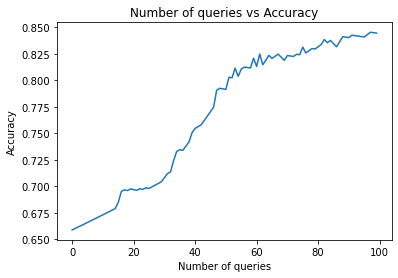

In [14]:
plot_accuracy(scores_zlg)

In [15]:
print('List of queried points')
print(queried_zlg)

List of queried points
[72, 442, 4, 196, 119, 4, 170, 455, 38, 412, 28, 100, 64, 217, 179, 107, 25, 0, 48, 372, 128, 302, 113, 330, 301, 29, 436, 242, 109, 157, 91, 437, 207, 17, 0, 291, 16, 40, 80, 113, 85, 348, 295, 42, 102, 95, 152, 108, 86, 287, 77, 310, 196, 99, 221, 80, 62, 366, 192, 75, 58, 63, 86, 379, 77, 41, 53, 132, 257, 140, 198, 255, 71, 97, 119, 244, 62, 369, 60, 303, 386, 131, 299, 3, 112, 201, 160, 64, 91, 115, 68, 110, 345, 358, 81, 40, 43, 165, 126, 145]


### Random Query

In [16]:
%%time

# copy data for use in this section
Xk_rand = copy.deepcopy(Xk)
Yk_rand = copy.deepcopy(Yk)
Xu_rand = copy.deepcopy(Xu)
Yu_rand = copy.deepcopy(Yu)

# variables
n_samples = X.shape[0]
n_l = Xk_rand.shape[0]
labeled_rand = [i for i in range(200)]
unlabeled_rand = [i for i in range(200,673)]

# initialize components
Delta = zlg.laplacian_matrix(X,t=0)
fu,Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_rand,unlabeled_rand,Yk)


# run required iterations
queried_rand = []
scores_rand = []
for count in range(100):
    
    # select unlabeled instance 
    query_idx = np.random.randint(low=0,high=len(unlabeled_rand),size=1)[0] # random unlabeled point
    queried_rand.append(query_idx)

    # add instance to labeled set
    Yk_rand = np.append(Yk_rand,Yu_rand[query_idx])
    Xk_rand = np.append(Xk_rand,[Xu_rand[query_idx,:]],axis=0)
    n_l += 1
    labeled_rand.append(unlabeled_rand.pop(0))  # move first element in unlabeled to end of labeled list

    # remove instance from unlabeled set
    Yu_rand = np.delete(Yu_rand,query_idx)
    Xu_rand = np.delete(Xu_rand,query_idx, 0)

    # update Laplacian
    Delta = zlg.laplacian_matrix(np.concatenate((Xk_rand,Xu_rand),axis=0), t=0)

    # calculate minimum energy solution for remaining unlabeled
    fu, Delta_uu_inv = zlg.minimum_energy_solution(Delta,labeled_rand, unlabeled_rand,Yk_rand)

    # score model by testing on all unlabeled points left at each step
    scores_rand.append(score_model(fu, Yu_rand))

CPU times: user 1min 54s, sys: 1.03 s, total: 1min 55s
Wall time: 56 s


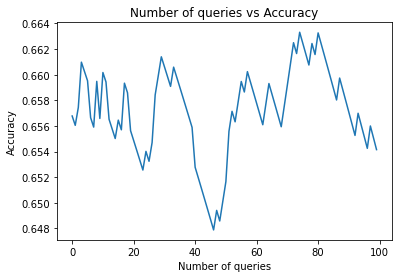

In [17]:
plot_accuracy(scores_rand)

In [18]:
print('List of queried points')
print(queried_rand)

List of queried points
[449, 223, 9, 4, 142, 401, 264, 351, 382, 210, 30, 262, 381, 388, 267, 231, 21, 184, 42, 54, 198, 15, 415, 298, 96, 218, 300, 392, 125, 23, 364, 389, 388, 101, 330, 193, 48, 434, 140, 236, 238, 162, 258, 247, 195, 200, 362, 35, 153, 209, 413, 275, 77, 119, 81, 345, 213, 277, 55, 150, 298, 312, 231, 165, 76, 309, 363, 228, 264, 391, 55, 36, 119, 137, 77, 161, 179, 372, 176, 350, 45, 299, 285, 201, 5, 26, 133, 34, 119, 313, 313, 366, 239, 71, 332, 173, 313, 64, 177, 288]


### Comparison

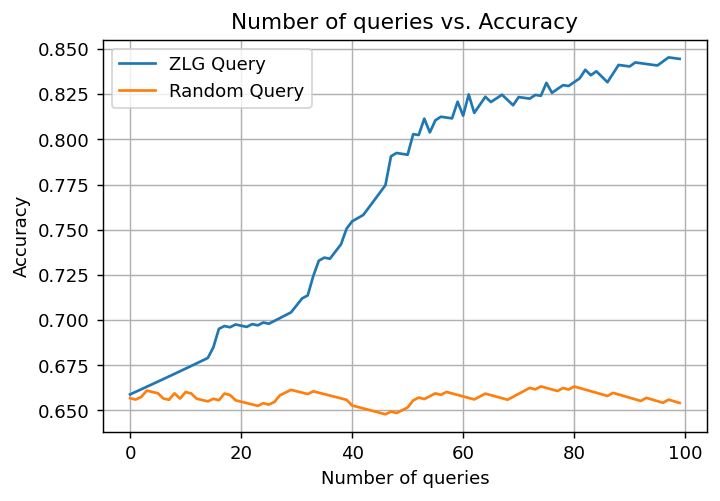

In [23]:
# plot both together
fig, ax = plt.subplots(dpi=130)
ax.plot(scores_zlg, label='ZLG Query')
ax.plot(scores_rand,label='Random Query')
plt.xlabel('Number of queries')
plt.ylabel('Accuracy')
plt.title('Number of queries vs. Accuracy')
plt.grid()
plt.legend()       
plt.show()

# 1.6. Bonus question 

**Answer the following questions. (Your grade will not exceed 100 for this homework.)**

#### 1. For this dataset, how many labeled data points do you actually need to train the model sufficiently well? 
#### 2. And why?